In [1]:
import json
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, random_split
from transformers import DetrImageProcessor, DetrForObjectDetection, TrainingArguments, Trainer, default_data_collator
from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor
import pandas as pd
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import seaborn as sns
import numpy as np

2025-04-21 08:01:18.167196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745222478.370108      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745222478.425016      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Lazy COCO-like Conversion Function
def convert_auair_to_detr_format_lazy(json_path, image_root):
    with open(json_path, "r") as f:
        auair_data = json.load(f)

    categories = auair_data["categories"]
    class_to_id = {name: idx for idx, name in enumerate(categories)}

    annotations = auair_data["annotations"]
    converted = []

    for image_id, ann in enumerate(annotations):
        file_name = ann["image_name"]
        width = int(ann["image_width:"])
        height = int(ann["image_height"])
        bboxes = ann["bbox"]

        bbox_list = []
        category_list = []
        area_list = []
        bbox_id_list = []

        for i, box in enumerate(bboxes):
            x_min = box["left"]
            y_min = box["top"]
            w = box["width"]
            h = box["height"]
            x_max = x_min + w
            y_max = y_min + h
            area = w * h

            bbox_list.append([x_min, y_min, x_max, y_max])
            category_list.append(box["class"])
            area_list.append(area)
            bbox_id_list.append(image_id * 1000 + i)

        converted.append({
            "image_id": image_id,
            "image_path": str(Path(image_root) / file_name),
            "width": width,
            "height": height,
            "objects": {
                "bbox_id": bbox_id_list,
                "category": category_list,
                "bbox": bbox_list,
                "area": area_list
            }
        })

    return converted

In [3]:
# Prepare Dataset and Processor
image_root = "/kaggle/input/di725-assignment2/images/images"
annotation_path = "/kaggle/input/di725-assignment2/annotations.json"
dataset_list = convert_auair_to_detr_format_lazy(annotation_path, image_root)

In [4]:
dataset_list[0]

{'image_id': 0,
 'image_path': '/kaggle/input/di725-assignment2/images/images/frame_20190829091111_x_0001973.jpg',
 'width': 1920,
 'height': 1080,
 'objects': {'bbox_id': [0, 1, 2],
  'category': [1, 1, 0],
  'bbox': [[1098, 163, 1518, 348],
   [1128, 421, 1521, 597],
   [1703, 927, 1886, 1080]],
  'area': [77700, 69168, 27999]}}

In [5]:
# Split data
train_val, test = train_test_split(dataset_list, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.2, random_state=42)

In [6]:
# Wrap as DatasetDict
dataset = DatasetDict({
    "train": Dataset.from_list(train),
    "val": Dataset.from_list(val),
    "test": Dataset.from_list(test)
})

In [7]:
dataset["train"][0]

{'image_id': 27693,
 'image_path': '/kaggle/input/di725-assignment2/images/images/frame_20190906150731_xx_0000129.jpg',
 'width': 1920,
 'height': 1080,
 'objects': {'area': [6732, 1550, 18128, 4002, 14536, 13760],
  'bbox': [[658, 665, 760, 731],
   [683, 636, 733, 667],
   [447, 665, 623, 768],
   [180, 595, 249, 653],
   [781, 638, 965, 717],
   [1364, 607, 1579, 671]],
  'bbox_id': [27693000, 27693001, 27693002, 27693003, 27693004, 27693005],
  'category': [5, 0, 1, 1, 1, 1]}}

In [8]:
train_data = dataset['train']
val_data = dataset['val']
test_data = dataset['test']

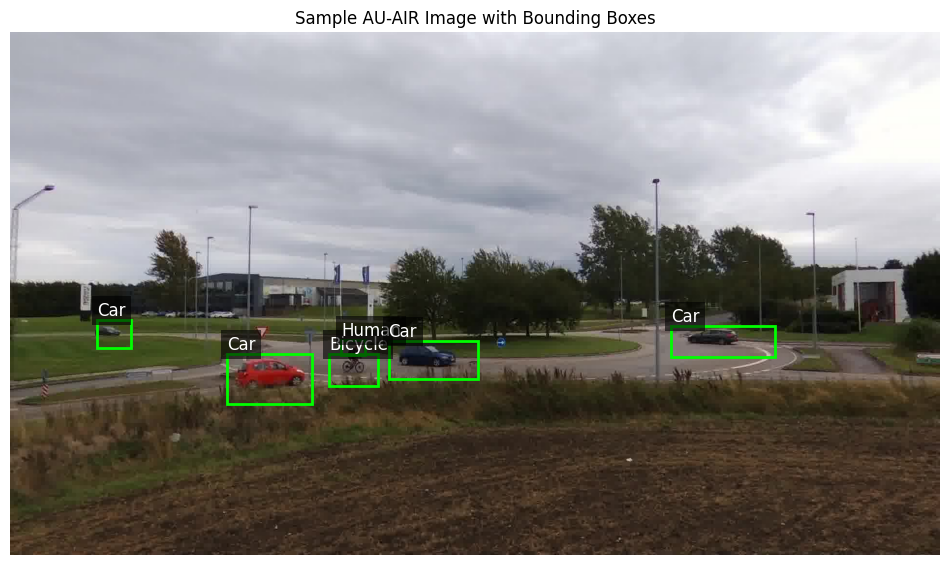

In [9]:
# Category mapping (hardcoded from your original AU-AIR structure)
categories = ["Human", "Car", "Truck", "Van", "Motorbike", "Bicycle", "Bus", "Trailer"]
id2label = {i: name for i, name in enumerate(categories)}

def visualize_auair_example(data_entry, id2label=id2label):
    image_path = data_entry["image_path"]
    image = Image.open(image_path).convert("RGB")
    width, height = image.size

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for bbox, cat_id in zip(data_entry["objects"]["bbox"], data_entry["objects"]["category"]):
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        label = id2label.get(cat_id, str(cat_id))

        # Draw rectangle
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2,
                                 edgecolor="lime", facecolor="none")
        ax.add_patch(rect)

        # Add label
        ax.text(x_min, y_min - 10, label, color="white", fontsize=12,
                bbox=dict(facecolor="black", alpha=0.6, edgecolor="none"))

    plt.title("Sample AU-AIR Image with Bounding Boxes")
    plt.axis("off")
    plt.show()

visualize_auair_example(train_data[0])

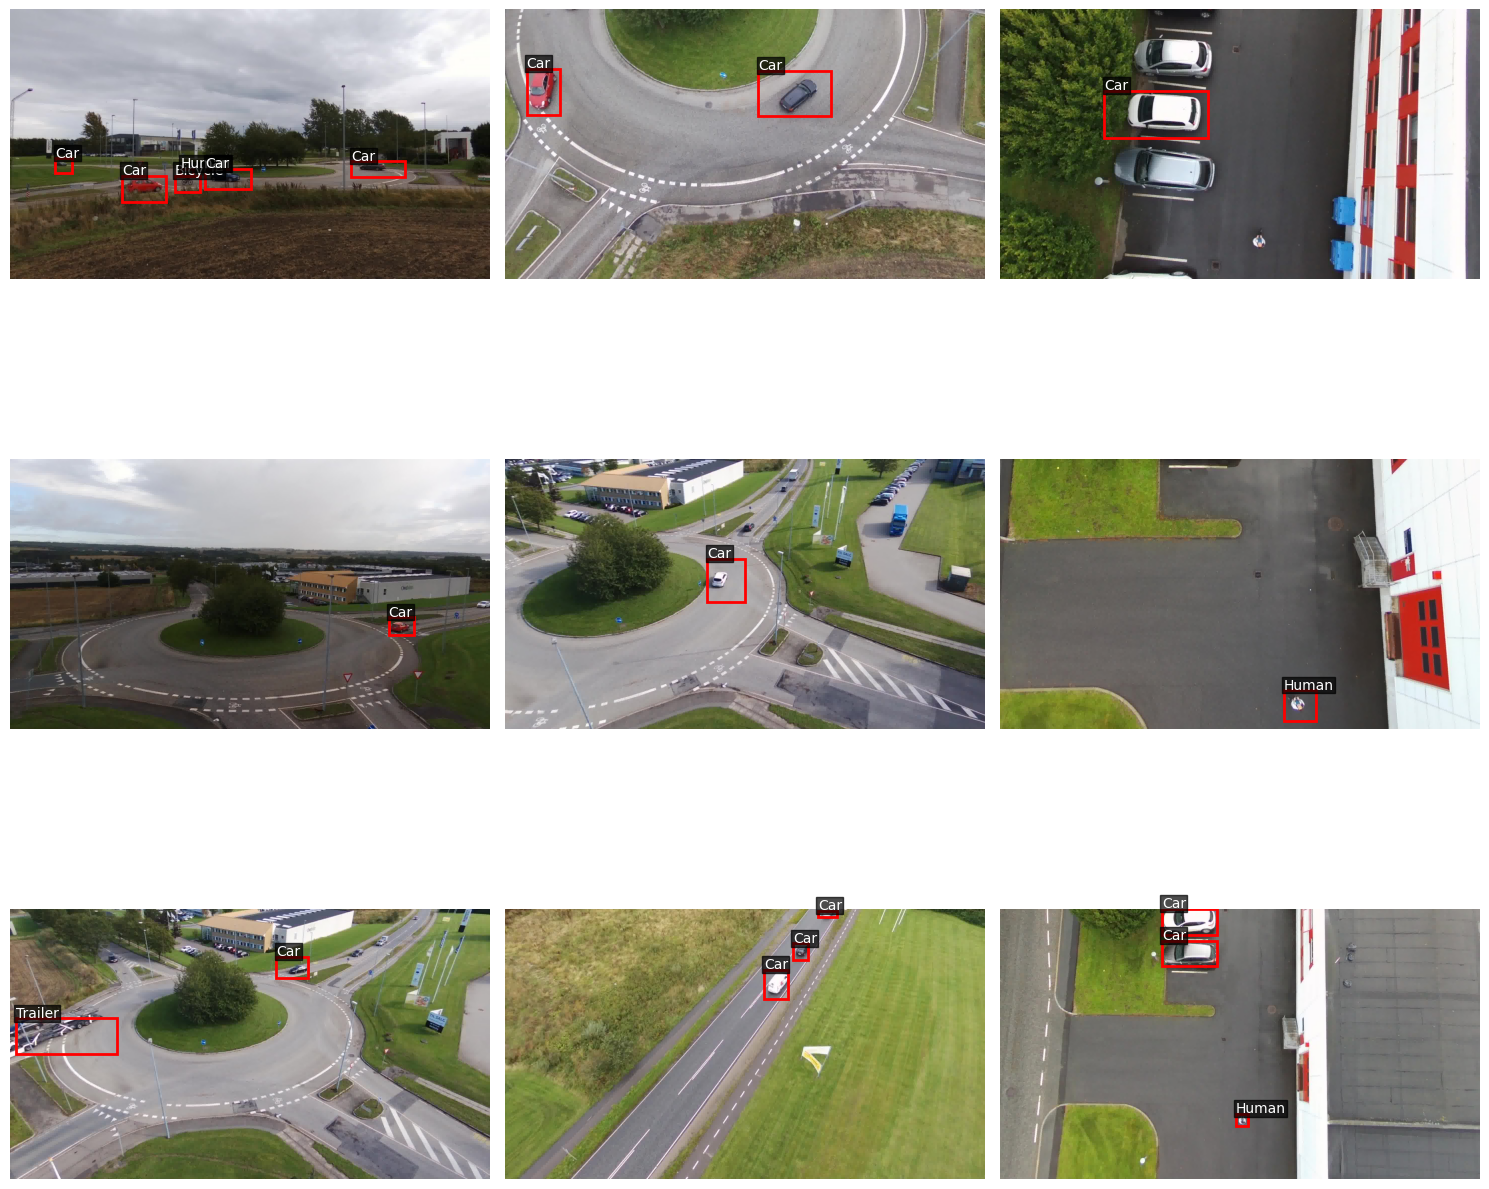

In [10]:
def plot_images(dataset, indices, id2label=id2label, cols=3):
    rows = (len(indices) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    if rows == 1:
        axs = [axs]  # single row edge case
    axs = axs.flatten()

    for ax, idx in zip(axs, indices):
        entry = dataset[idx]
        image = Image.open(entry["image_path"]).convert("RGB")
        ax.imshow(image)

        for bbox, cat_id in zip(entry["objects"]["bbox"], entry["objects"]["category"]):
            x_min, y_min, x_max, y_max = bbox
            w = x_max - x_min
            h = y_max - y_min
            label = id2label.get(cat_id, str(cat_id))

            rect = patches.Rectangle((x_min, y_min), w, h, linewidth=2,
                                     edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min - 5, label, color='white',
                    fontsize=10, bbox=dict(facecolor='black', alpha=0.7, pad=1))

        ax.axis("off")

    # Hide any unused subplots
    for j in range(len(indices), len(axs)):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_images(train_data, range(9))

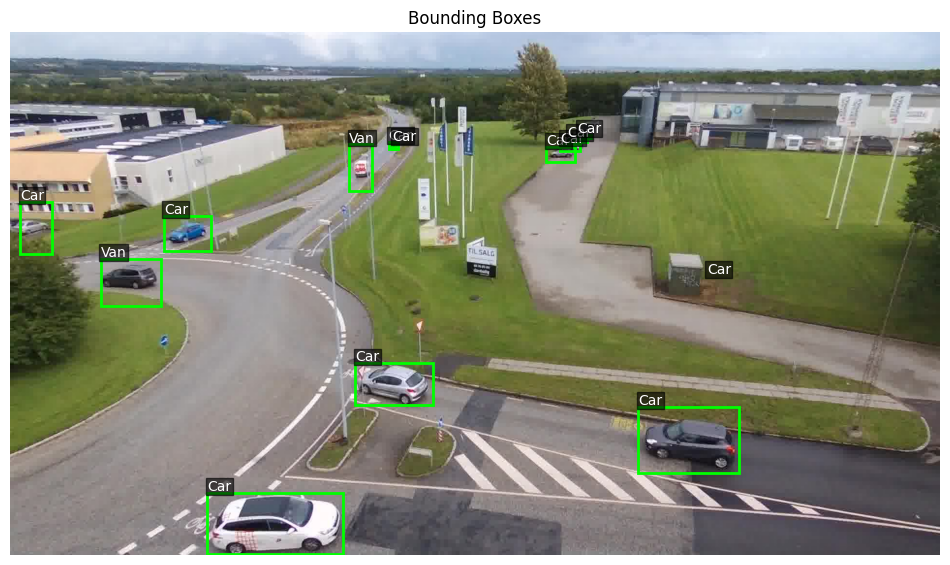

In [11]:
def visualize_raw_entry(entry, id2label=None, highlight_invalid=True):
    image = Image.open(entry["image_path"]).convert("RGB")
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for i, box in enumerate(entry["objects"]["bbox"]):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        label = (
            id2label[entry["objects"]["category"][i]]
            if id2label else str(entry["objects"]["category"][i])
        )

        is_valid = (x_max > x_min) and (y_max > y_min)

        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=2,
            edgecolor='lime' if is_valid else 'red',
            facecolor='none'
        )
        ax.add_patch(rect)

        ax.text(
            x_min, y_min - 5, label,
            color="white", fontsize=10,
            bbox=dict(facecolor="black", alpha=0.6, pad=1)
        )

    ax.set_title("Bounding Boxes" if highlight_invalid else "Bounding Boxes")
    plt.axis("off")
    plt.show()

entry_23057 = next(e for e in dataset["train"] if e["image_id"] == 23057)
visualize_raw_entry(entry_23057, id2label=id2label)

Before applying our filtering function to discard invalid bounding boxes, we performed a manual visual inspection of selected samples flagged as problematic. This step was essential to verify that the automatic detection of invalid annotations correctly identified entries that are indeed unusable during model training.

In [12]:
def filter_invalid_bboxes(entry):
    """
    Removes bounding boxes that have invalid geometry.
    Specifically, boxes where x_max <= x_min or y_max <= y_min are considered invalid.
    """
    valid_bbox = []
    valid_cat = []
    valid_area = []
    valid_ids = []

    for i, box in enumerate(entry["objects"]["bbox"]):
        try:
            x_min, y_min, x_max, y_max = box
            if (x_max > x_min) and (y_max > y_min):
                valid_bbox.append(box)
                valid_cat.append(entry["objects"]["category"][i])
                valid_area.append(entry["objects"]["area"][i])
                valid_ids.append(entry["objects"]["bbox_id"][i])
            else:
                print(
                    f"[WARNING] Invalid box skipped: {box} in image {entry['image_id']} "
                    f"→ Area might be zero or negative."
                )
        except Exception as e:
            print(f"[ERROR] Could not process bbox {box} in image {entry['image_id']}: {e}")
            continue

    entry["objects"]["bbox"] = valid_bbox
    entry["objects"]["category"] = valid_cat
    entry["objects"]["area"] = valid_area
    entry["objects"]["bbox_id"] = valid_ids

    return entry

In [13]:
train_data = train_data.map(filter_invalid_bboxes)
val_data = val_data.map(filter_invalid_bboxes)

Map:   0%|          | 0/21006 [00:00<?, ? examples/s]

[WARNING] Invalid box skipped: [1438, 503, 1438, 503] in image 23057 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1329, 557, 1329, 557] in image 22689 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1666, 441, 1666, 441] in image 28654 → Area might be zero or negative.
[WARNING] Invalid box skipped: [802, 98, 802, 102] in image 15453 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1640, 347, 1640, 347] in image 13389 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1441, 850, 1441, 850] in image 28802 → Area might be zero or negative.
[WARNING] Invalid box skipped: [677, 398, 677, 398] in image 8705 → Area might be zero or negative.
[WARNING] Invalid box skipped: [680, 389, 680, 389] in image 8705 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1327, 793, 1327, 793] in image 24218 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1485, 562, 1485, 562] in image 22732 → Area might 

Map:   0%|          | 0/5252 [00:00<?, ? examples/s]

[WARNING] Invalid box skipped: [653, 485, 653, 485] in image 25366 → Area might be zero or negative.
[WARNING] Invalid box skipped: [585, 0, 585, 0] in image 23913 → Area might be zero or negative.
[WARNING] Invalid box skipped: [0, 1080, 0, 1080] in image 32051 → Area might be zero or negative.
[WARNING] Invalid box skipped: [78, 288, 78, 288] in image 32051 → Area might be zero or negative.
[WARNING] Invalid box skipped: [128, 280, 128, 280] in image 32051 → Area might be zero or negative.
[WARNING] Invalid box skipped: [1061, 925, 1061, 925] in image 26324 → Area might be zero or negative.
[WARNING] Invalid box skipped: [886, 766, 886, 766] in image 25011 → Area might be zero or negative.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


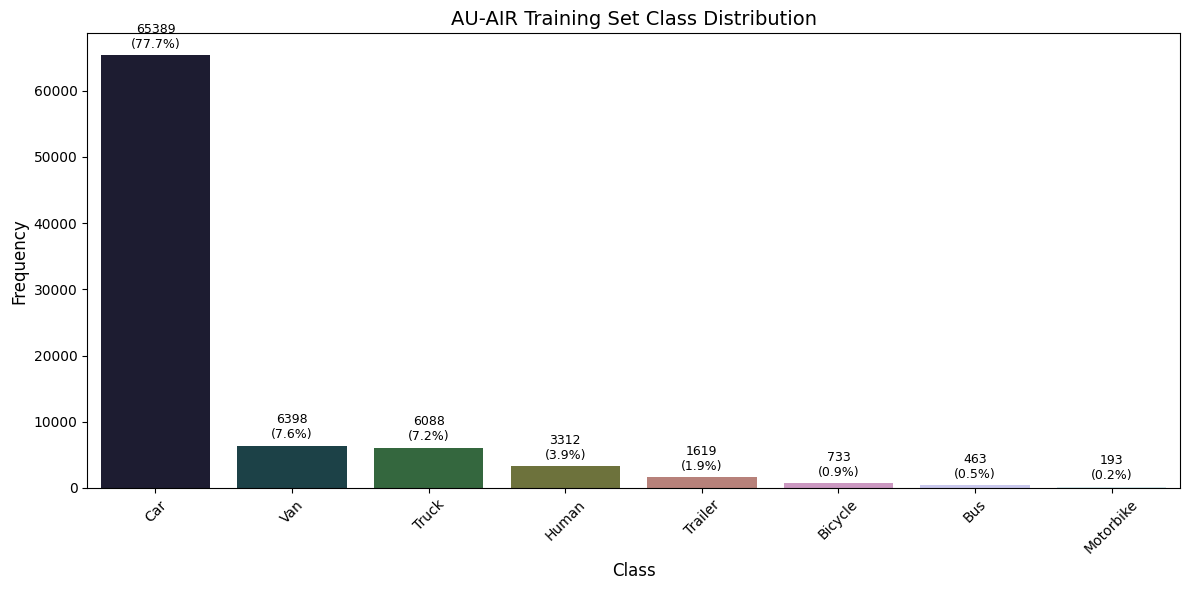

In [14]:
# Count occurrences
all_labels = []
for example in train_data:
    all_labels.extend(example['objects']['category'])

label_counts = Counter(all_labels)
total = sum(label_counts.values())

# Map to category names and prepare dataframe
class_data = [
    {
        "label": id2label[class_id],
        "count": count,
        "percent": (count / total) * 100
    }
    for class_id, count in label_counts.items()
]

class_data = sorted(class_data, key=lambda x: x["count"], reverse=True)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=[entry["label"] for entry in class_data],
    y=[entry["count"] for entry in class_data],
    palette="cubehelix"
)

# Add value labels
for i, entry in enumerate(class_data):
    ax.text(
        i, entry["count"] + max(label_counts.values()) * 0.01,
        f'{entry["count"]}\n({entry["percent"]:.1f}%)',
        ha='center', va='bottom', fontsize=9, color='black'
    )

plt.title("AU-AIR Training Set Class Distribution", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
#pip install albumentations

In [16]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.MotionBlur(p=0.2),
    A.Resize(800, 800),
],
bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [17]:
# Initialize processor (standard DETR processor)
checkpoint = "facebook/detr-resnet-50-dc5"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [18]:
class AUAirDETRDataset(torch.utils.data.Dataset):
    def __init__(self, data_list, processor, transform=None):
        self.data_list = data_list  # list of dicts, not HuggingFace dataset
        self.processor = processor
        self.transform = transform

    def __getitem__(self, idx):
        entry = self.data_list[idx]  # ⚠️ Expecting a single index

        image = np.array(Image.open(entry["image_path"]).convert("RGB"))

        bboxes = []
        category_ids = []
        for box, label in zip(entry["objects"]["bbox"], entry["objects"]["category"]):
            x_min, y_min, x_max, y_max = box
            bboxes.append([x_min, y_min, x_max, y_max])
            category_ids.append(label)

        # Apply albumentations transform if provided
        if self.transform:
            transformed = self.transform(image=image, bboxes=bboxes, category_ids=category_ids)
            image = transformed["image"]
            bboxes = transformed["bboxes"]
            category_ids = transformed["category_ids"]

        # Convert bbox to DETR format [x, y, width, height]
        annotations = [
            {
                "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
                "category_id": cat_id,
                "area": (x_max - x_min) * (y_max - y_min),
                "iscrowd": 0
            }
            for (x_min, y_min, x_max, y_max), cat_id in zip(bboxes, category_ids)
        ]

        # Use processor
        encoding = self.processor(
            images=image,
            annotations={"image_id": entry["image_id"], "annotations": annotations},
            return_tensors="pt"
        )

        return {
            "pixel_values": encoding["pixel_values"].squeeze(0),
            "labels": encoding["labels"][0]
        }

    def __len__(self):
        return len(self.data_list)

In [19]:
train_list = train_data.to_list()
val_list = val_data.to_list()
test_list = test_data.to_list()

train_dataset = AUAirDETRDataset(train_list, image_processor)
val_dataset = AUAirDETRDataset(val_list, image_processor)
test_dataset = AUAirDETRDataset(test_list, image_processor)

print("Train Dataset Type:", type(train_dataset))

Train Dataset Type: <class '__main__.AUAirDETRDataset'>


In [20]:
from transformers import AutoModelForObjectDetection

label2id = {v: k for k, v in id2label.items()}

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
).to("cuda" if torch.cuda.is_available() else "cpu")

# Freeze EVERYTHING
for param in model.parameters():
    param.requires_grad = False

# Unfreeze ONLY prediction heads
for param in model.class_labels_classifier.parameters():
    param.requires_grad = True

for param in model.bbox_predictor.parameters():
    param.requires_grad = True

config.json:   0%|          | 0.00/4.38k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2400: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

In [21]:
example = train_dataset[0]
print(example.keys())

dict_keys(['pixel_values', 'labels'])


In [22]:
print("CUDA Available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

CUDA Available: True
Device: Tesla P100-PCIE-16GB


In [23]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: esrasekerci (esrasekerci-metu-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [24]:
from torch.utils.data import Dataset
from PIL import Image
import torch

class AUAirCustomDataset(Dataset):
    def __init__(self, data_list, image_processor, label2id):
        self.data = data_list
        self.processor = image_processor
        self.label2id = label2id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item["image_path"]).convert("RGB")

        bboxes = item["objects"]["bbox"]
        categories = item["objects"]["category"]
        areas = item["objects"]["area"]

        annotations = {
            "image_id": item["image_id"],
            "annotations": [
                {
                    "category_id": cat_id,
                    "bbox": bbox,
                    "area": area,
                    "iscrowd": 0
                }
                for cat_id, bbox, area in zip(categories, bboxes, areas)
            ]
        }

        processed = self.processor(images=image, annotations=annotations, return_tensors="pt")
        return {
            "pixel_values": processed["pixel_values"].squeeze(),
            "labels": processed["labels"][0]
        }

In [25]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50-dc5")

train_dataset = AUAirCustomDataset(train_data.to_list(), image_processor, label2id)
val_dataset = AUAirCustomDataset(val_data.to_list(), image_processor, label2id)
test_dataset = AUAirCustomDataset(test_data.to_list(), image_processor, label2id)

from torch.utils.data import DataLoader

def detr_collate_fn(batch):
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    labels = [x["labels"] for x in batch]
    return {"pixel_values": pixel_values, "labels": labels}

In [26]:
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import wandb
wandb.login()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# W&B setup (set your API key if needed)
os.environ["WANDB_PROJECT"] = "detr-auair"
wandb.init(
    project="detr-auair",
    name="custom-training-loop",
    config={
        "model": "facebook/detr-resnet-50-dc5",
        "epochs": 3,
        "batch_size": 8,
        "optimizer": "AdamW",
        "lr": 5e-5,
        "weight_decay": 0.01
    }
)

# Safe label-to-device utility
def move_labels_to_device(labels, device):
    new_labels = []
    for label in labels:
        new_label = {}
        for k, v in label.items():
            if isinstance(v, torch.Tensor):
                new_label[k] = v.to(device)
            elif isinstance(v, list):
                new_label[k] = torch.tensor(v, device=device)
            elif isinstance(v, (int, float)):
                new_label[k] = torch.tensor([v], device=device)
            else:
                raise TypeError(f"Unsupported type {type(v)} in labels")
        new_labels.append(new_label)
    return new_labels

# Collate function
def detr_collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = [item["labels"] for item in batch]
    return {"pixel_values": pixel_values, "labels": labels}

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=detr_collate_fn, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=detr_collate_fn, num_workers=0)

# Training loop
epochs = 3
model.to(device)

for epoch in range(epochs):
    print(f"\n🔥 Training Epoch {epoch+1}")
    model.train()
    total_train_loss = 0.0

    for step, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        batch = {
            "pixel_values": batch["pixel_values"].to(device),
            "labels": move_labels_to_device(batch["labels"], device)
        }

        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}"):
            batch = {
                "pixel_values": batch["pixel_values"].to(device),
                "labels": move_labels_to_device(batch["labels"], device)
            }
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # ✅ Print and log to W&B
    print(f"✅ Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss
    })

# Save model
torch.save(model.state_dict(), "detr_auair_finetuned2.pth")
print("✅ Model saved.")

# Close W&B run
wandb.finish()

✅ Using device: cuda


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.



🔥 Training Epoch 1


Training Epoch 1:   0%|          | 0/2626 [00:00<?, ?it/s]

Validating Epoch 1:   0%|          | 0/657 [00:00<?, ?it/s]

✅ Epoch 1 | Train Loss: 1.4610 | Val Loss: 0.9721

🔥 Training Epoch 2


Training Epoch 2:   0%|          | 0/2626 [00:00<?, ?it/s]

Validating Epoch 2:   0%|          | 0/657 [00:00<?, ?it/s]

✅ Epoch 2 | Train Loss: 0.9296 | Val Loss: 0.8682

🔥 Training Epoch 3


Training Epoch 3:   0%|          | 0/2626 [00:00<?, ?it/s]

Validating Epoch 3:   0%|          | 0/657 [00:00<?, ?it/s]

✅ Epoch 3 | Train Loss: 0.8724 | Val Loss: 0.8399
✅ Model saved.


epoch,▁▅█
train_loss,█▂▁
val_loss,█▂▁
epoch,3
train_loss,0.87238
val_loss,0.83987


In [27]:
import torch
from torch.utils.data import DataLoader
from transformers import DetrConfig, DetrForObjectDetection
from tqdm import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Test DataLoader
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=detr_collate_fn)

# Initialize mAP evaluator
metric = MeanAveragePrecision(iou_type="bbox", class_metrics=True)

# Evaluation loop
for batch in tqdm(test_loader, desc="Evaluating on Test Set"):
    pixel_values = batch["pixel_values"].to(device)
    labels = batch["labels"]

    labels = [
        {
            "boxes": l["boxes"].to(device),
            "labels": l["class_labels"].to(device)
        } for l in labels
    ]

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)

    preds = []
    for logit, box in zip(outputs.logits, outputs.pred_boxes):
        probs = logit.softmax(-1)[..., :-1]  # remove background class
        scores, classes = probs.max(-1)
        preds.append({
            "boxes": box.cpu(),
            "scores": scores.cpu(),
            "labels": classes.cpu()
        })

    targets = [
        {
            "boxes": l["boxes"].cpu(),
            "labels": l["labels"].cpu()
        }
        for l in labels
    ]

    metric.update(preds, targets)

Evaluating on Test Set: 100%|██████████| 3283/3283 [24:07<00:00,  2.27it/s]


In [28]:
# Final mAP results
results = metric.compute()

print("\n📊 COCO-style mAP Evaluation Results:\n")
for k, v in results.items():
    if isinstance(v, torch.Tensor) and v.numel() == 1:
        print(f"{k:<25}: {v.item():.4f}")
    elif "per_class" in k:
        print(f"\n{k} (per class):")
        for i, value in enumerate(v):
            print(f"  {id2label[i]:<12}: {value.item():.4f}")


📊 COCO-style mAP Evaluation Results:

map                      : 0.0002
map_50                   : 0.0008
map_75                   : 0.0000
map_small                : 0.0002
map_medium               : -1.0000
map_large                : -1.0000
mar_1                    : 0.0001
mar_10                   : 0.0002
mar_100                  : 0.0002
mar_small                : 0.0002
mar_medium               : -1.0000
mar_large                : -1.0000

map_per_class (per class):
  Human       : 0.0000
  Car         : 0.0000
  Truck       : 0.0015
  Van         : 0.0000
  Motorbike   : 0.0000
  Bicycle     : 0.0000
  Bus         : 0.0000
  Trailer     : 0.0000

mar_100_per_class (per class):
  Human       : 0.0000
  Car         : 0.0003
  Truck       : 0.0011
  Van         : 0.0004
  Motorbike   : 0.0000
  Bicycle     : 0.0000
  Bus         : 0.0000
  Trailer     : 0.0000


In [30]:
from IPython.display import FileLink

# Creates a clickable download link
FileLink("detr_auair_finetuned2.pth")

/kaggle/working/detr_auair_finetuned2.pth

In [31]:
import shutil

# Move to output directory
shutil.move("detr_auair_finetuned2.pth", "/kaggle/working/detr_auair_finetuned2.pth")

'/kaggle/working/detr_auair_finetuned2.pth'

In [32]:
wandb.init()
wandb.save("detr_auair_finetuned2.pth")

['/kaggle/working/wandb/run-20250421_131319-irw1nnm2/files/detr_auair_finetuned2.pth']